### **Predicción de Enfermedad Cardíaca con SVM**

Este notebook tiene como objetivo desarrollar y evaluar un modelo de Support Vector Machine (SVM) para clasificar la presencia de enfermedad cardíaca, comparando kernels lineales y no lineales, y evaluando el impacto del escalado y la selección de hiperparámetros.

Este notebook desarrolla y evalúa un modelo de clasificación para predecir la presencia de enfermedad cardíaca (`target=1`) a partir de variables clínicas.

El análisis incluye:
- preparación y preprocesamiento de los datos,
- entrenamiento de modelos SVM con distintos kernels,
- selección de hiperparámetros,
- y evaluación del desempeño predictivo en un conjunto de test.

Este análisis no pretende construir un modelo clínicamente validado, sino demostrar un flujo completo de modelado predictivo, desde la limpieza de datos hasta la evaluación de calibración, utilizando un dataset público.

In [52]:
# Importaciones y configuración del entorno
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_auc_score, roc_curve,
    average_precision_score,
    RocCurveDisplay, PrecisionRecallDisplay, accuracy_score
)

from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import brier_score_loss
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [5]:
# Carga del dataset
from google.colab import drive
import os
import pandas as pd

drive.mount("/content/drive")

path = "/content/drive/MyDrive/Estudios/Posgrado Austral/Proyectos/heart.csv"
df = pd.read_csv(path, sep=",", decimal=".", skipinitialspace=True)

# Dataset: dimensiones y primeras filas
print("Dimensión (filas, columnas):", df.shape)
display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dimensión (filas, columnas): (1025, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


El dataset tiene 1025 observaciones y 14 variables (13 predictoras y una variable objetivo target). La variable target indica presencia (1) o ausencia (0) de enfermedad cardíaca.

In [47]:
# Tipos de datos, cantidad de observaciones y valores no nulos
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       302 non-null    int64  
 1   sex       302 non-null    int64  
 2   cp        302 non-null    int64  
 3   trestbps  302 non-null    int64  
 4   chol      302 non-null    int64  
 5   fbs       302 non-null    int64  
 6   restecg   302 non-null    int64  
 7   thalach   302 non-null    int64  
 8   exang     302 non-null    int64  
 9   oldpeak   302 non-null    float64
 10  slope     302 non-null    int64  
 11  ca        302 non-null    int64  
 12  thal      302 non-null    int64  
 13  target    302 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.2 KB
None


Todas las variables están codificadas numéricamente.

Explicación de las variables:
*   `age`: edad en años.
*   `sex`: 1 = male; 0 = female.
*   `cp`: tipo de dolor de pecho (0-3).
*   `trestbps`: presión arterial en descanso (en mm Hg en la admisión al hospital).
*   `chol`: colesterol en mg/dl
*   `fbs`: presión arterial en ayunas > 120 mg/dl
*   `restecg`: resultados electrocardiográficos en reposo (valores 0,1,2).
*   `thalach`: frecuencia cardíaca máxima alcanzada.
*   `exang`: angina inducida por el ejercicio (1 = sí, 0 = no).
*   `oldpeak` = depresión del segmento ST inducida por el ejercicio en relación con el reposo.

In [48]:
# Valores faltantes por variable
print("\nMissing values per column:\n", df.isna().sum().sort_values(ascending=False).head(10))


Missing values per column:
 age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
dtype: int64


No hay *missing values* en ninguna variable.

In [49]:
# Evaluación del balance de la variable objetivo
print("\nTarget distribution:\n", df["target"].value_counts(normalize=True).round(3))


Target distribution:
 target
1    0.543
0    0.457
Name: proportion, dtype: float64


La prevalencia de la clase positiva es del 54%, lo que indica un dataset relativamente balanceado.

In [28]:
# Chequeo de duplicados
dup_total = df.duplicated().sum()
print(f"Duplicados exactos: {dup_total} / {len(df)} ({dup_total/len(df):.1%})")

df = df.drop_duplicates().reset_index(drop=True)
print("Dimensión tras deduplicar:", df.shape)

Duplicados exactos: 723 / 1025 (70.5%)
Dimensión tras deduplicar: (302, 14)


Se detectó una proporción muy alta de observaciones duplicadas (≈70%), lo que puede inflar artificialmente el desempeño si las mismas filas caen tanto en train como en test. Para evitarlo, se eliminaron duplicados exactos antes del split.

In [29]:
# Definición de características (X) y variable objetivo (y)
# En este dataset, target = 1 indica presencia de enfermedad cardíaca; target = 0 indica ausencia.
X = df.drop(columns=["target"])
y = df["target"].astype(int)

cat_cols = ["sex","cp","fbs","restecg","exang","slope","ca","thal"]
num_cols = ["age","trestbps","chol","thalach","oldpeak"]

print("X:", X.shape, "| y:", y.shape, "| prevalencia:", y.mean().round(3))

X: (302, 13) | y: (302,) | prevalencia: 0.543


In [30]:
# División en conjuntos de entrenamiento y prueba (train/test split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Prevalencia train:", y_train.mean().round(3), "| test:", y_test.mean().round(3))

Train: (226, 13) | Test: (76, 13)
Prevalencia train: 0.544 | test: 0.539


Se realizó un particionado train/test (75/25) estratificado por la variable objetivo, garantizando proporciones de clase similares en ambos conjuntos. El conjunto de prueba se reservó exclusivamente para la evaluación final, mientras que la selección de hiperparámetros se realizó únicamente sobre el conjunto de entrenamiento mediante validación cruzada.

In [31]:
# Variables numéricas: imputación de medianas y estandarización
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Variables categóricas: imputación de la moda y One-hot encoding
cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

pre = ColumnTransformer([
    ("num", num_pipe, num_cols),
    ("cat", cat_pipe, cat_cols)
])

Las variables numéricas se imputaron con mediana y se estandarizaron, dado que SVM es sensible a la escala. Las variables categóricas se imputaron con la moda y se codificaron mediante one-hot encoding, ignorando categorías desconocidas para asegurar robustez al evaluar en test.

**Búsqueda de hiperparámetros óptimos (C y gamma) mediante GridSearchCV**

In [50]:
# CV estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5 folds, estratificado (mantiene proporción de clases en cada fold)

svm_pipe = Pipeline([
    ("pre", pre),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

# Grilla de hiperparámetros
param_grid = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__gamma": ["scale", 0.01, 0.1, 1]
}

# Búsqueda en grilla con CV optimizando AUC
grid = GridSearchCV(
    svm_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=0
)

# Entrenar la búsqueda (solo en train)
grid.fit(X_train, y_train)

best_idx = grid.best_index_
mean_auc = grid.cv_results_["mean_test_score"][best_idx]
std_auc  = grid.cv_results_["std_test_score"][best_idx]

print("Mejores parámetros:", grid.best_params_)
print(f"Mejor AUC CV (train): {mean_auc:.4f} ± {std_auc:.4f}")

best_model = grid.best_estimator_

Mejores parámetros: {'clf__C': 1, 'clf__gamma': 0.01}
Mejor AUC CV (train): 0.9129 ± 0.0337


Se ajustó un SVM con kernel RBF mediante validación cruzada estratificada (5-fold), optimizando el AUC ROC. La mejor configuración alcanzó un AUC promedio de 0.913 (± 0.034) en CV, con parámetros C=1 y gamma=0.01, lo que sugiere un compromiso adecuado entre complejidad del modelo y generalización.



In [38]:
# Evaluación del mejor modelo en el conjunto de prueba (Heart Disease)
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred  = best_model.predict(X_test)

print("Accuracy test:", round(accuracy_score(y_test, y_pred), 4))
print("AUC ROC test:", round(roc_auc_score(y_test, y_proba), 4))
print("AP (PR AUC) test:", round(average_precision_score(y_test, y_proba), 4))

print("\nReporte:\n", classification_report(y_test, y_pred, digits=3))

Accuracy test: 0.8421
AUC ROC test: 0.9038
AP (PR AUC) test: 0.9043

Reporte:
               precision    recall  f1-score   support

           0      0.848     0.800     0.824        35
           1      0.837     0.878     0.857        41

    accuracy                          0.842        76
   macro avg      0.843     0.839     0.840        76
weighted avg      0.842     0.842     0.842        76



En el conjunto de prueba, el modelo SVM con kernel RBF alcanzó una accuracy del 84,2 %, un AUC ROC de 0,904 y un PR AUC de 0,904.

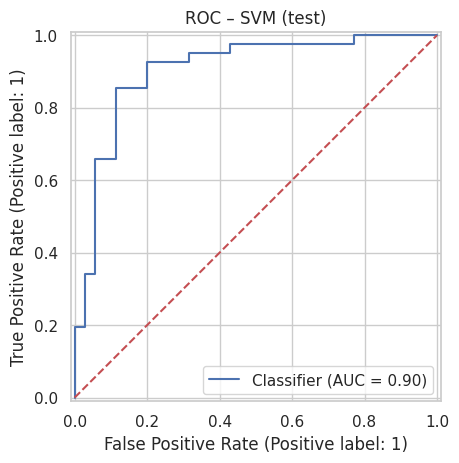

In [39]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.plot([0,1],[0,1],'r--')
plt.title("ROC – SVM (test)")
plt.show()

In [51]:
# Umbral óptimo según Youden
fpr, tpr, thr = roc_curve(y_test, y_proba)
youden = tpr - fpr
best_thr = thr[np.argmax(youden)]

print(f"Umbral óptimo (Youden): {best_thr:.4f}")

# Predicción con umbral óptimo
y_pred_thr = (y_proba >= best_thr).astype(int)

print("\nReporte (umbral óptimo):")
print(classification_report(y_test, y_pred_thr, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_thr))

Umbral óptimo (Youden): 0.5318

Reporte (umbral óptimo):
              precision    recall  f1-score   support

           0      0.838     0.886     0.861        35
           1      0.897     0.854     0.875        41

    accuracy                          0.868        76
   macro avg      0.868     0.870     0.868        76
weighted avg      0.870     0.868     0.869        76

Confusion matrix:
 [[31  4]
 [ 6 35]]


El AUC ROC (0.904) resume la capacidad discriminativa global del modelo y es independiente del umbral de clasificación. A partir de esta curva se seleccionó un umbral óptimo mediante el índice de Youden, lo que permitió traducir dicha capacidad discriminativa en una mejora concreta de las métricas de clasificación puntual (accuracy, sensibilidad y especificidad).

Brier score: 0.122


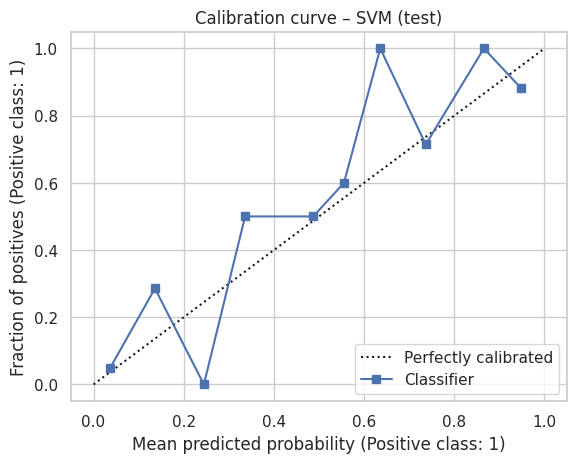

In [42]:
print("Brier score:", brier_score_loss(y_test, y_proba).round(4))

CalibrationDisplay.from_predictions(y_test, y_proba, n_bins=10)
plt.title("Calibration curve – SVM (test)")
plt.show()

La calibración del modelo fue evaluada mediante el Brier score y la curva de calibración. El Brier score obtenido (0.122) indica un error relativamente bajo en las probabilidades predichas, lo que sugiere que el modelo genera estimaciones de riesgo razonablemente calibradas.

In [53]:
# Datos preprocesados
X_test_pre = best_model.named_steps["pre"].transform(X_test)

# PCA a 2 componentes
pca = PCA(n_components=2, random_state=42)
X_test_pca = pca.fit_transform(X_test_pre)

print("Varianza explicada por PC1 y PC2:",
      pca.explained_variance_ratio_.round(3))

Varianza explicada por PC1 y PC2: [0.28  0.155]


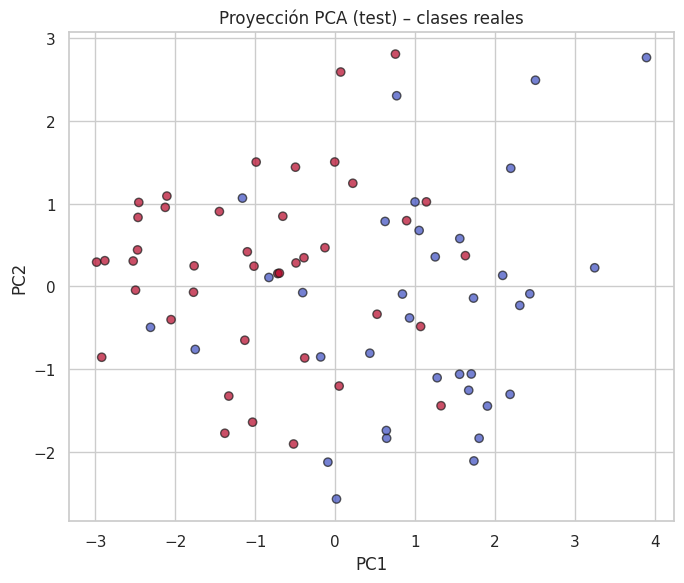

In [54]:
plt.figure(figsize=(7, 6))

plt.scatter(
    X_test_pca[:, 0],
    X_test_pca[:, 1],
    c=y_test,
    cmap="coolwarm",
    edgecolor="k",
    alpha=0.7,
    label="Clase real"
)

plt.title("Proyección PCA (test) – clases reales")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

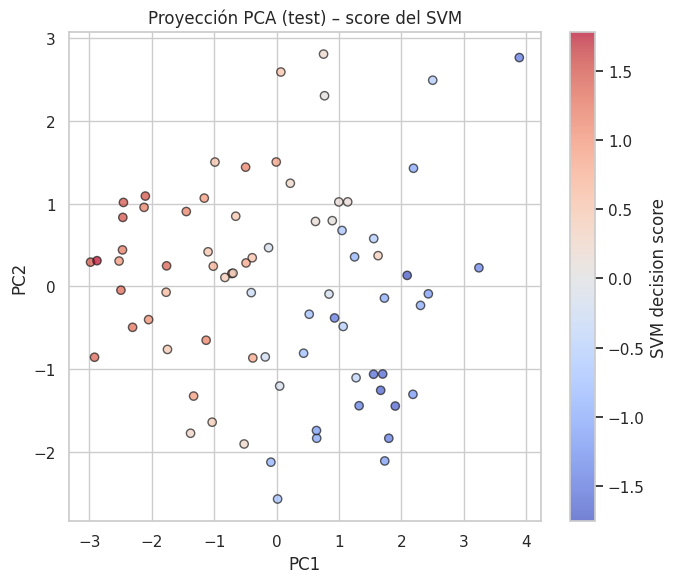

In [55]:
scores = best_model.decision_function(X_test)

plt.figure(figsize=(7, 6))

plt.scatter(
    X_test_pca[:, 0],
    X_test_pca[:, 1],
    c=scores,
    cmap="coolwarm",
    edgecolor="k",
    alpha=0.7
)

plt.colorbar(label="SVM decision score")
plt.title("Proyección PCA (test) – score del SVM")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

Dado que el modelo SVM con kernel RBF opera en un espacio de alta dimensión, la frontera de decisión no puede visualizarse directamente. Para obtener una representación intuitiva, los datos preprocesados se proyectaron a dos dimensiones mediante PCA. Se observa un buen desempeño discriminativo del modelo, aunque sin una separación lineal perfecta que es esperable.

### **Conclusiones**

En este trabajo se desarrolló un modelo de clasificación binaria para enfermedad cardíaca utilizando SVM con kernel RBF.

El modelo mostró buena capacidad discriminativa y estabilidad en validación cruzada, manteniendo un desempeño consistente en el conjunto de prueba. La optimización del umbral permitió mejorar las métricas de clasificación puntual, mientras que el análisis de calibración evidenció probabilidades razonablemente bien ajustadas.